# Imports

In [1]:

# imports
# basic
import numpy as np
from flatland.envs.rail_env import RailEnv
from flatland.envs.rail_env import TrainState
# for rendering
import PIL
from flatland.utils.rendertools import RenderTool
from IPython.display import clear_output
# for plotting
import matplotlib.pyplot as plt
# for running clingo
import json
import subprocess
import os
import pickle

# Functions

In [2]:
# render the environment
def render_env(env,wait=True):
    
    env_renderer = RenderTool(env, gl="PILSVG", screen_width=2000, screen_height=2000)
    env_renderer.render_env()

    image = env_renderer.get_image()
    pil_image = PIL.Image.fromarray(image)
    pil_image = pil_image.convert("RGB")

    clear_output(wait=True)
    display(pil_image)

In [3]:
# get global transitions
def get_transitions(obsx):
    transitions = obsx[0][0]
    x = 0
    atoms = []

    for i in transitions:
        y = 0
        for j in i:
            directions = ["(\"N\",\"N\")", "(\"N\",\"E\")", "(\"N\",\"S\")", "(\"N\",\"W\")", "(\"E\",\"N\")", "(\"E\",\"E\")", "(\"E\",\"S\")", "(\"E\",\"W\")", "(\"S\",\"N\")", "(\"S\",\"E\")", "(\"S\",\"S\")", "(\"S\",\"W\")", "(\"W\",\"N\")", "(\"W\",\"E\")", "(\"W\",\"S\")", "(\"W\",\"W\")"]
            usableDirections = [directions[i] for i, bit in enumerate(j) if bit == 1]

            for k in usableDirections:
                atoms.append(f"transition(({x},{y}),{k})")
            y += 1
        x += 1

    return atoms

In [4]:
# extract info of an agent
def get_agents(agent):
    atoms = []

    # state(A,(X,Y),T,D)
    # A - agent handle
    # (X,Y) - position of the agent
    # T - time til earliest departure
    # D - direction "N", "E", "S" or "W"
    directions = {0:"\"N\"", 1:"\"E\"", 2:"\"S\"", 3:"\"W\""}
    initialstate = "initialstate(" + str(agent.handle) + ", (" + str(agent.initial_position) + ", " + str(directions[agent.direction]) + "), " + str(agent.earliest_departure) + ")"
    atoms.append(initialstate)

    # target(A,(X,Y),T)
    # A - agent handle
    # (X,Y) - position of the target
    # T - time til latest arrival
    target = "target(" + str(agent.handle) + ", "+str(agent.target) + ", " + str(agent.latest_arrival) + ")"
    atoms.append(target)

    # speed(A,S)
    # A - agent handle
    # S - steps taken for one transition
    speed = "speed(" + str(agent.handle) + ", " + str(agent.speed_counter.max_count+1) + ")"
    atoms.append(speed)

    return(atoms)

In [5]:
# get all atoms combined (agents and transitions)
def get_atoms(env,obs):
    # get atoms
    agent_handles = env.get_agent_handles()
    atoms = get_transitions(obs[agent_handles[0]])
    for i in agent_handles:
        atoms = atoms + get_agents(env.agents[i])

    # export atoms
    atoms.append("")
    output = ". ".join(atoms)

    return output

In [6]:
# limit memory of a subprocess
def limit_memory(ram_limit):
    # Define a function to set resource limits
    import resource
    def set_limits():
        resource.setrlimit(resource.RLIMIT_AS, (ram_limit*1024**3, ram_limit*1024**3))
    return set_limits

In [7]:
# run a .lp file
def run_clingo(input_data, encoding, timeout, ram_limit):
    command = ["clingo", "-", encoding, "--outf=2"]

    try:
        output = subprocess.check_output(
            command,
            timeout=timeout,
            stderr=subprocess.DEVNULL,
            input=input_data.encode("utf-8"),
            preexec_fn=limit_memory(ram_limit)).decode("utf-8")

    except subprocess.TimeoutExpired:
        return "TIMEOUT"
    except subprocess.CalledProcessError as e:
        # This is no Error this is the normal way clingo exits
        # Whoever made this should be stoned

        # But it also embodies errors, so here is the memory one:
        if e.returncode == 33:
            return "MEMORY"
        if e.returncode == 20:
            return "UNSATISFIABLE"

        # And here is the output to make it work
        return e.output

In [8]:
# run a .py file
def run_python(input_data, program, timeout, ram_limit):
    command = ["python", program]

    try:
        output = subprocess.check_output(
            command,
            timeout=timeout,
            stderr=subprocess.DEVNULL,
            input=input_data.encode("utf-8"),
            preexec_fn=limit_memory(ram_limit)).decode("utf-8")

    except subprocess.TimeoutExpired:
        return "TIMEOUT"
    except subprocess.CalledProcessError as e:
        if e.returncode == 20:
            return "UNSATISFIABLE"
        else:
            return "MEMORY"
    except Exception as e:
        print(f"Problem with Python {e=}, {type(e)=}")
        raise

    return output.encode("utf-8")

In [9]:
# run an encoding folder
def run(input_data, encoding, timeout, ram_limit):
    dirs = os.listdir(encoding)
    list.sort(dirs)
    dirs = [i for i in dirs if "step" in i]

    total_time = 0
    solve_time = 0
    output_atoms = input_data

    for i in dirs:
        if ".lp" in i:
            output = run_clingo(input_data, encoding + i, timeout, ram_limit)
            if (output == "TIMEOUT") | (output == "MEMORY") | (output == "UNSATISFIABLE"):
                return output, None, None, None
        if ".py" in i:
            output = run_python(input_data, encoding + i, timeout, ram_limit)
            if (output == "TIMEOUT") | (output == "MEMORY") | (output == "UNSATISFIABLE"):
                return output, None, None, None

        jq_output = subprocess.check_output(["jq"], input=output)
        data = json.loads(jq_output)

        total_time += data["Time"]["Total"]
        solve_time += data["Time"]["Solve"]
        output_atoms = data["Call"][-1]["Witnesses"][0]["Value"]
        input_data = output_atoms.copy()

        input_data.append("")
        input_data = ".".join(input_data)
        
    return "SATISFIABLE", total_time, solve_time, output_atoms

In [10]:
# convert facts to flatland orders
def facts_to_flatland(atoms):
    dictionaries = {}

    # Iterate through the values
    for atom in atoms:
        parts = atom.split(",")
        x = int(parts[0].split("(")[1])
        a = int(parts[1])
        t = int(parts[2].strip(")\""))

        # Create a dictionary for x if it doesn't exist
        if x not in dictionaries:
            dictionaries[x] = {}

        # Add the corresponding d to the dictionary with t as the key
        dictionaries[x][t] = a

    return dictionaries

In [11]:
# run the orders
def run_orders(env, plan):
    t = 0

    while True:
        dictionary = {}
        for i in plan:
            if t in plan[i]: value = plan[i][t]
            else: value = 0
            dictionary[i] = int(value)
    
        print(str(t) + ": "+ str(dict(sorted(dictionary.items()))))
        obs, rew, done, info = env.step(dictionary)
        render_env(env,True)

        t += 1

        if done["__all__"]:
            return all(info["state"][i] == TrainState.DONE for i in info["state"]), t

In [12]:
# run an instance manually
def run_manually(env):
    c = 0
    while True:
        dictionary = {}
        for i in env.get_agent_handles():
            print("Order for agent " + str(i) + ":")
            order = input()
            if order: dictionary[i] = int(order)
            else: dictionary[i] = 0
    
        input()
        obs, rew, done, info = env.step(dictionary)
        render_env(env,True)


        if done["__all__"]: break

# Example

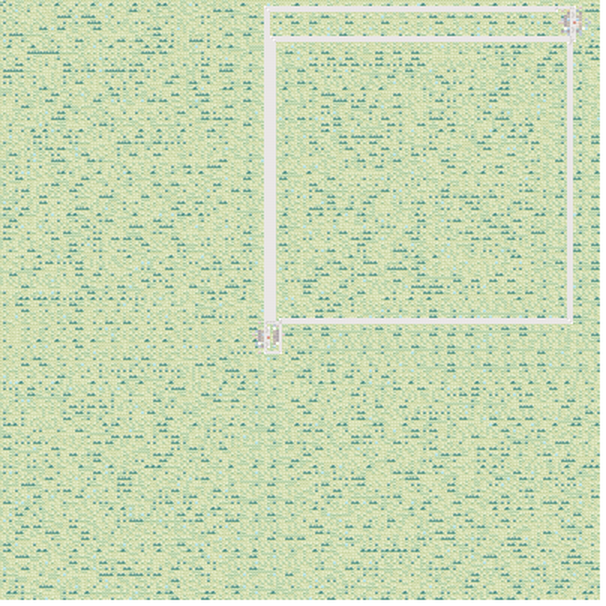

KeyboardInterrupt: 

In [13]:
# open a .pkl with a flatland instance
# could be replaced with generating it here
filename = "200x200_030/ex00"
with open("testing/flatland/objects/" + filename + ".pkl", "rb") as file:
    env = pickle.load(file)

obs = env.reset()

# deactivate the horizon
render_env(env,True)

# generate the input atoms
input_atoms = get_atoms(env,obs)

# orders = get_orders("testing/flatland/facts/" + filename + ".lp","encodings/multiple/ordered/combined.lp")
sat, time, solve, atoms = run(input_atoms, "encodings/multiple/path_assigning/", 600, 10)
orders = facts_to_flatland(atoms)

output = dict(sorted(orders.items()))
for i in output:
    output[i] = dict(sorted(output[i].items()))
print(output)

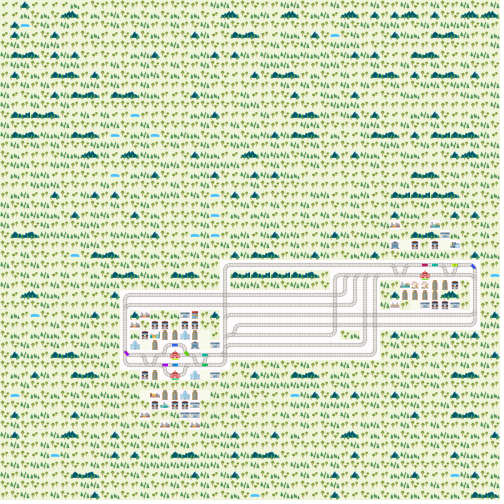

9: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0}


KeyboardInterrupt: 

In [ ]:
# run the plan with the instance

# remove horizon (necessary for ordered_pipe)
# env._max_episode_steps = None

# run encoding
print(run_orders(env,orders))
# run_manually(env)